# Mini-project 2 - Pre-processing of the IMDB data

In [ ]:
import numpy as np
%matplotlib inline                                 
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace  
import scipy.sparse as sparse
import pandas as pd
import seaborn as sns

np.random.seed(1234)

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
path='/content/drive/My Drive/Colab Notebooks/COMP551_mini_proj2'

Mounted at /content/drive


## Import all reviews

Import the csv file built by the merge_imdb.py script with the following columns:
- review
- dataset
- label
- rating

In [ ]:
df = pd.read_csv(path+'/imdb_data/imdb_all.csv', delimiter = ';')

In [ ]:
print('Dimensions of the whole dataset:', df.shape)

print('\nFirst 3 rows of the dataset:\n', df.iloc[:3])

Dimensions of the whole dataset: (50000, 4)

First 3 rows of the dataset:
                                               review dataset label  rating
0  alan rickman & emma thompson give good perform...    test   neg       4
1  i have seen this movie and i did not care for ...    test   neg       1
2  in los angeles the alcoholic and lazy hank chi...    test   neg       4


## Plot the class distribution

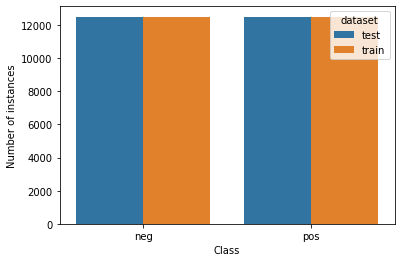

In [ ]:
ax = sns.countplot(x='label', hue ='dataset', data=df)
ax.set(xlabel='Class', ylabel='Number of instances')
plt.savefig(path+'/figures/imdb_labels.png')
plt.show()

Plot the rating distribution.

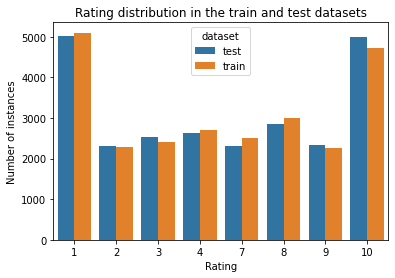

In [ ]:
ax = sns.countplot(x='rating', hue ='dataset', data=df)
ax.set(xlabel='Rating', ylabel='Number of instances', title='Rating distribution in the train and test datasets')
plt.savefig(path+'/figures/imdb_ratings.png')
plt.show()

## Create train and test reviews and labels

In [ ]:
reviews_train = df.loc[df["dataset"] == 'train', "review"]
y_train = df.loc[df["dataset"] == 'train', "label"]
y_train = y_train.replace({'neg': 0, 'pos': 1})

reviews_test = df.loc[df["dataset"] == 'test', "review"]
y_test = df.loc[df["dataset"] == 'test', "label"]
y_test = y_test.replace({'neg': 0, 'pos': 1})
print(reviews_train.shape, y_train.shape, reviews_test.shape, y_test.shape)
print('\nreviews_train:\n', reviews_train.head(n=2), '\ny_train:\n', y_train.head(n=2), '\nreviews_test:\n', reviews_test.head(n=2), '\ny_test:\n', y_test.head(n=2))

(25000,) (25000,) (25000,) (25000,)

reviews_train:
 25000    working with one of the best shakespeare sourc...
25001    welltremors i the original started off in 1990...
Name: review, dtype: object 
y_train:
 25000    0
25001    0
Name: label, dtype: int64 
reviews_test:
 0    alan rickman & emma thompson give good perform...
1    i have seen this movie and i did not care for ...
Name: review, dtype: object 
y_test:
 0    0
1    0
Name: label, dtype: int64


## Text vectorization

### Basic vectorization removing stopwords

Create the feature matrices x_train and x_test: rows=instances, columns=words, 

*   List item
*   List item

values=Present/Absent

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(binary=True, stop_words=['in','of','at','a','the'])
x_train = count_vect.fit_transform(reviews_train)
x_train.shape

(25000, 92711)

In [ ]:
x_test = count_vect.transform(reviews_test)
x_test.shape

(25000, 92711)

Visualize the sparse matrix (blue dots are non-zero values).

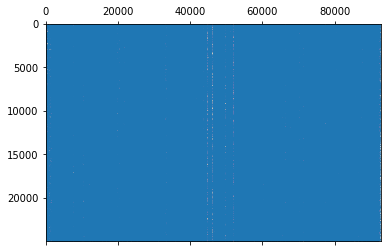

In [ ]:
plt.spy(x_train, markersize=0.05, aspect='auto')

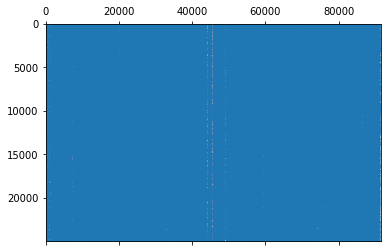

In [ ]:
plt.spy(x_test, markersize=0.05, aspect='auto')

### Vectorization using bigrams





In [ ]:
count_vect_bigrams = CountVectorizer(binary=True, ngram_range=(1, 2), stop_words=['in','of','at','a','the'])
x_train_bigrams = count_vect_bigrams.fit_transform(reviews_train)
print(x_train_bigrams.shape)
x_test_bigrams = count_vect_bigrams.transform(reviews_test)
print(x_test_bigrams.shape)

(25000, 1729766)
(25000, 1729766)


### Vectorization using word counts

In [ ]:
freq_vect = CountVectorizer(ngram_range=(1, 2), stop_words=['in','of','at','a','the'])
x_train_freq = freq_vect.fit_transform(reviews_train)
print(x_train_freq.shape)
x_test_freq = freq_vect.transform(reviews_test)
print(x_test_freq.shape)



(25000, 1729766)
(25000, 1729766)


### Vectorization using term frequency - inverse document frequency

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect = TfidfVectorizer(ngram_range=(1, 2), stop_words=['in','of','at','a','the'])
x_train_tfidf = tfidf_vect.fit_transform(reviews_train)
print(x_train_tfidf.shape)
x_test_tfidf = tfidf_vect.transform(reviews_test)
print(x_test_tfidf.shape)

(25000, 1729766)
(25000, 1729766)


## Cross-validation and accuracy functions

For linear regression, we use Root Mean Squared Error to evaluate the performance of the model.

In [ ]:
def evaluate_acc_linreg(y, yh):
  accuracy = np.sqrt(np.mean((y-yh)**2))
  return accuracy

In [ ]:
def cross_validation_split(x_train,y_train,k_folds):
  
  #get size of validation set
  n_val = x_train.shape[0] // k_folds
  #initialize lists and dictionaries to store data and labels for different folds
  full_train = []
  full_val = []
  #labels are stored in dictionary to prevent rounding from k_folds to store different sized arrays
  #list works with data because it is in list of csr matrix
  y_cv_train = {}
  y_cv_val = {}
  
  
  for f in range(k_folds):
      tr_inds = []
      #get the validation indexes
      val_inds = list(range(f * n_val, (f+1)*n_val))
      #get the train indexes
      if f > 0:
          tr_inds = list(range(f*n_val))
      if f < k_folds - 1:
          tr_inds = tr_inds + list(range((f+1)*n_val, x_train.shape[0]))
      
      #store training data
      x_cv_train = x_train.tocsr()[tr_inds,:]
      y_cv_train['fold_'+str(f)] = np.take(y_train,tr_inds)
      #store validation data
      x_cv_val = x_train.tocsr()[val_inds,:]
      y_cv_val['fold_'+str(f)] = np.take(y_train,val_inds)
      
      full_train.append(x_cv_train)
      full_val.append(x_cv_val)
  return full_train, full_val, y_cv_train, y_cv_val


#runs the cross validation
def kfoldCV(full_train,full_val,y_cv_train,y_cv_val,model):
  k_folds = len(full_train)
  acc = []
  for i in range(k_folds):
    model.fit(full_train[i],y_cv_train['fold_'+str(i)])
    yh = model.predict(full_val[i])
    acc.append(evaluate_acc_linreg(y_cv_val['fold_'+str(i)], yh))
  return acc

## Linear regression for ratings

Create labels arrays for test and train dataset.

In [ ]:
y_train_rat = df.loc[df["dataset"] == 'train', "rating"]
y_train_rat = y_train_rat.to_numpy()
y_test_rat = df.loc[df["dataset"] == 'test', "rating"]
y_test_rat = y_test_rat.to_numpy()

print(y_train_rat.shape, y_test_rat.shape)
print('\ny_train_rat:\n', y_train_rat[:10], '\ny_test_rat:\n', y_test_rat[:10])

(25000,) (25000,)

y_train_rat:
 [4 1 4 1 3 3 4 2 1 1] 
y_test_rat:
 [4 1 4 2 1 4 2 4 3 4]


Fit and predict with linear regression model.

In [ ]:
from sklearn.linear_model import LinearRegression

preprocess_x = [x_train, x_train_bigrams, x_train_freq, x_train_tfidf]
mean_acc_list = []
prepro_nb = 0

for prepro in preprocess_x:
    lin_model = LinearRegression()
    train_set, val_set, y_cv_train, y_cv_val = cross_validation_split(prepro,y_train_rat,k_folds=5)
    errors = kfoldCV(train_set,val_set,y_cv_train,y_cv_val,lin_model)
    mean_acc = np.mean(errors)
    mean_acc_list.append(mean_acc)
    print('For preprocessed datasat #',prepro_nb,'the mean RMSE is:',mean_acc)
    prepro_nb += 1

For preprocessed datasat # 0 the mean RMSE is: 4.450266585621577
For preprocessed datasat # 0 the mean RMSE is: 2.6014902359761267
For preprocessed datasat # 0 the mean RMSE is: 2.8527897873518873
For preprocessed datasat # 0 the mean RMSE is: 2.2754898519108555


### Hyperparameter tuning for linear regression

We continue with the tf_idf preprocessed dataset as it is the one that gives the lower RMSE with linear regression.

Scaling the features to center the data between -1 and 1 for regularization.




In [ ]:
from sklearn.preprocessing import MaxAbsScaler

transformer = MaxAbsScaler().fit(x_train_tfidf)
x_train_tfidf_scaled = transformer.transform(x_train_tfidf)
x_test_tfidf_scaled = transformer.transform(x_test_tfidf)

Testing L1 regularization to determine if the model is better than basic linear regression. We test different lambda values for regularization.

In [ ]:
from sklearn import linear_model

alpha_list = [0.01,0.1,1,10,100]
mean_acc_list = []

for alpha in alpha_list:
    lin_model_l1 = linear_model.Lasso(alpha = alpha)
    train_set, val_set, y_cv_train, y_cv_val = cross_validation_split(x_train_tfidf_scaled,y_train_rat,k_folds=5)
    acc = kfoldCV(train_set,val_set,y_cv_train,y_cv_val,lin_model_l1)
    mean_acc = np.mean(acc)
    mean_acc_list.append(mean_acc)
    print('For regularization term =',alpha,'the mean RMSE is:',mean_acc)


We test a mix of L1 and L2 regularization.

In [ ]:
from sklearn.linear_model import ElasticNet

alpha_list = [0.01,0.1,1]
l1_ratio = [0.25,0.5,0.75]
mean_acc_list_elast = []

for alpha in alpha_list:
  for l1 in l1_ratio:
    lin_model_elasticnet = ElasticNet(alpha = alpha, l1_ratio=l1)
    train_set, val_set, y_cv_train, y_cv_val = cross_validation_split(x_train_tfidf_scaled,y_train_rat,k_folds=5)
    acc = kfoldCV(train_set,val_set,y_cv_train,y_cv_val,lin_model_elasticnet)
    mean_acc = np.mean(acc)
    mean_acc_list_elast.append(mean_acc)
    print('For regularization term =',alpha,'For l1 ratio =',l1,'the mean RMSE is:',mean_acc)

For regularization term = 0.01 For l1 ratio = 0.25 the mean RMSE is: 2.9692716684564524
For regularization term = 0.01 For l1 ratio = 0.5 the mean RMSE is: 3.0927220343373074
For regularization term = 0.01 For l1 ratio = 0.75 the mean RMSE is: 3.1487260828768244
For regularization term = 0.1 For l1 ratio = 0.25 the mean RMSE is: 4.008416760696623
For regularization term = 0.1 For l1 ratio = 0.5 the mean RMSE is: 4.076897946612997
For regularization term = 0.1 For l1 ratio = 0.75 the mean RMSE is: 4.087227157248584
For regularization term = 1 For l1 ratio = 0.25 the mean RMSE is: 4.087227157248584
For regularization term = 1 For l1 ratio = 0.5 the mean RMSE is: 4.087227157248584
For regularization term = 1 For l1 ratio = 0.75 the mean RMSE is: 4.087227157248584


We test pure L2 regularization.

In [ ]:
from sklearn.linear_model import Ridge

alpha_list = [0.001,0.01,0.1,1,10,100]
solver_list = ['lsqr', 'saga']
mean_acc_list_ridge = []

for solver in solver_list:
  for alpha in alpha_list:
    lin_model_ridge = Ridge(alpha = alpha, solver=solver, fit_intercept=False)
    train_set, val_set, y_cv_train, y_cv_val = cross_validation_split(x_train_tfidf_scaled,y_train_rat,k_folds=5)
    acc = kfoldCV(train_set,val_set,y_cv_train,y_cv_val,lin_model_ridge)
    mean_acc = np.mean(acc)
    mean_acc_list_ridge.append(mean_acc)
    print('For solver',solver,'and regularization term =',alpha,'the mean RMSE is:',mean_acc)

For solver lsqr and regularization term = 0.001 the mean RMSE is: 2.682221045994189
For solver lsqr and regularization term = 0.01 the mean RMSE is: 2.681882008470933
For solver lsqr and regularization term = 0.1 the mean RMSE is: 2.682837440734533
For solver lsqr and regularization term = 1 the mean RMSE is: 2.6838054645575555
For solver lsqr and regularization term = 10 the mean RMSE is: 2.6964564823839106
For solver lsqr and regularization term = 100 the mean RMSE is: 2.8618097007191867
For solver saga and regularization term = 0.001 the mean RMSE is: 2.680965221510676
For solver saga and regularization term = 0.01 the mean RMSE is: 2.6810594396352974
For solver saga and regularization term = 0.1 the mean RMSE is: 2.6811112196857287
For solver saga and regularization term = 1 the mean RMSE is: 2.682978568802508
For solver saga and regularization term = 10 the mean RMSE is: 2.6981660964674434
For solver saga and regularization term = 100 the mean RMSE is: 2.8670263964400653


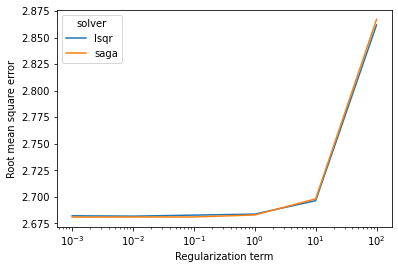

In [ ]:
df.plot = pd.DataFrame(mean_acc_list_ridge,columns=['rmse'])
df.plot['solver'] = ['lsqr']*6 + ['saga']*6
df.plot['alpha'] = alpha_list*2

import seaborn as sns
ax = sns.lineplot(x="alpha", y="rmse", hue="solver", data=df.plot)
ax.set(xscale="log", xlabel='Regularization term', ylabel='Root mean square error')
plt.savefig(path+'/figures/linreg_hyperparam.png')
plt.show()

## Experiments for linear regression

Train the model on the whole train dataset and report performance on the test dataset.

### Basic linear regression (ordinary least squares)

In [ ]:
from sklearn.linear_model import LinearRegression

lin_model = LinearRegression()
lin_model.fit(x_train_tfidf,y_train_rat)
yh = lin_model.predict(x_test_tfidf)
print('RMSE is:',evaluate_acc_linreg(y_test_rat, yh))


RMSE is: 2.0759081121272756


### Ridge regression with best hyperparameter

In [ ]:
from sklearn.linear_model import Ridge

lin_model_ridge = Ridge(alpha = 10, solver='saga', fit_intercept=False)
lin_model_ridge.fit(x_train_tfidf_scaled,y_train_rat)
yh = lin_model_ridge.predict(x_test_tfidf_scaled)
print('RMSE is:',evaluate_acc_linreg(y_test_rat, yh))

RMSE is: 2.618782596467862


### Performance according to the size of the dataset

In [ ]:
# Split the training set into different sizes
def size_split(x_train, y_train, n_test_list):
  x_train_sizes_list = []
  y_train_sizes_list = []
  for n in n_test_list:
    num_instances = x_train.shape[0]
    inds = np.random.permutation(num_instances)
    n_test = int(num_instances*n) - 1
    
    #shuffle the data
    x_train_sizes = x_train.tocsr()[inds,]
    y_train_sizes = y_train[inds]

    #store data
    x_train_sizes = x_train_sizes[:n_test,:]
    x_train_sizes_list.append(x_train_sizes)

    y_train_sizes = y_train_sizes[:n_test]
    y_train_sizes_list.append(y_train_sizes)

  return x_train_sizes_list, y_train_sizes_list

In [ ]:
n_sizes = [0.2, 0.4, 0.6, 0.8, 1]
x_train_sizes_list, y_train_sizes_list = size_split(x_train_tfidf, y_train_rat, n_test_list=n_sizes)

[2.226117709369042, 2.146778004196603, 2.1104947280325157, 2.0887204659806367, 2.075900190883697]


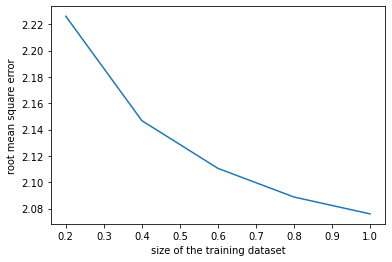

In [ ]:
from sklearn.linear_model import LinearRegression

err_test = []

for i in range(len(x_train_sizes_list)):
    lin_model = LinearRegression()
    lin_model.fit(x_train_sizes_list[i], y_train_sizes_list[i])
    yh = lin_model.predict(x_test_tfidf)
    err_test.append(evaluate_acc_linreg(y_test_rat, yh))

print(err_test)
plt.plot(n_sizes, err_test, '-')
plt.xlabel('size of the training dataset')
plt.ylabel('root mean square error')
plt.savefig(path+'/figures/linreg_error_sizetraining.png')
plt.show()